In [1]:
from datetime import datetime
import pytz
import pandas as pd
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

from datetime import datetime
import pytz

from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
import pandas as pd


# Retrieve data from elasticsearch

In [2]:
es = Elasticsearch('http://localhost:9200/')

In [3]:
def get_data_from_elastic():
    # query: The elasticsearch query.
    query = {
        "query": {
            "match_all" : {}
            }
    }

    # Scan function to get all the data. 
    rel = scan(client=es,             
               query=query,                                     
               scroll='1m',
               index='filebeat_data',
               raise_on_error=True,
               preserve_order=False,
               clear_scroll=True)
    # Keep response in a list.
    result = list(rel)
    temp = []
    # We need only '_source', which has all the fields required.
    # This elimantes the elasticsearch metdata like _id, _type, _index.
    for hit in result:
        temp.append(hit['_source'])
    # Create a dataframe.
    data = pd.DataFrame(temp)
    return data

In [4]:
df = get_data_from_elastic()

/tmp/ipykernel_3391/2756215264.py:18: ElasticsearchWarning:

Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.



In [5]:
df.head()

,response_code,referrer,timestamp,ip_address,user_name,url,content_size,request,host,path,http_version,@version,message,user_agent
0,200,http://mail.realforce.ch/,18/Nov/2021:02:23:04 +0000,208.100.26.249,-,/,42,GET,rim-VirtualBox,/home/rim/Documents/los_22022022/log/nginx/ngi...,1,1,208.100.26.249 - - [18/Nov/2021:02:23:04 +0000...,Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKi...
1,200,-,19/Nov/2021:09:34:39 +0000,23.146.242.252,-,/,21,GET,rim-VirtualBox,/home/rim/Documents/los_22022022/log/nginx/ngi...,1,1,23.146.242.252 - - [19/Nov/2021:09:34:39 +0000...,Mozilla/5.0 (Windows NT 10.0; WOW64; rv:47.0) ...
2,200,-,28/Nov/2021:12:53:31 +0000,51.158.108.77,-,/,21,GET,rim-VirtualBox,/home/rim/Documents/los_22022022/log/nginx/ngi...,1,1,51.158.108.77 - - [28/Nov/2021:12:53:31 +0000]...,-
3,200,-,02/Dec/2021:14:01:26 +0000,208.100.26.249,-,/,42,GET,rim-VirtualBox,/home/rim/Documents/los_22022022/log/nginx/ngi...,1,1,208.100.26.249 - - [02/Dec/2021:14:01:26 +0000...,Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7....
4,200,-,02/Dec/2021:16:30:35 +0000,159.203.66.140,-,/,11,GET,rim-VirtualBox,/home/rim/Documents/los_22022022/log/nginx/ngi...,1,1,159.203.66.140 - - [02/Dec/2021:16:30:35 +0000...,Mozilla/5.0 (compatible; NetcraftSurveyAgent/1...


In [6]:
df.isnull().any()

response_code    False
referrer         False
timestamp        False
ip_address       False
user_name        False
url              False
content_size     False
request          False
host             False
path             False
http_version     False
@version         False
message          False
user_agent       False
dtype: bool

In [7]:
data=df[['ip_address','timestamp','request','response_code','url','content_size','user_agent']]


In [8]:
data['timestamp']

0      18/Nov/2021:02:23:04 +0000
1      19/Nov/2021:09:34:39 +0000
2      28/Nov/2021:12:53:31 +0000
3      02/Dec/2021:14:01:26 +0000
4      02/Dec/2021:16:30:35 +0000
                  ...            
345    26/Dec/2021:12:00:34 +0000
346    26/Dec/2021:12:00:34 +0000
347    30/Dec/2021:11:07:55 +0000
348    30/Dec/2021:11:07:55 +0000
349    30/Dec/2021:23:05:13 +0000
Name: timestamp, Length: 350, dtype: object

In [9]:
from datetime import datetime
import pytz
def parse_datetime(x):
    '''
    Parses datetime with timezone formatted as:
        `[day/month/year:hour:minute:second zone]`

    Example:
        `>>> parse_datetime('13/Nov/2015:11:45:42 +0000')`
        `datetime.datetime(2015, 11, 3, 11, 45, 4, tzinfo=<UTC>)`

    Due to problems parsing the timezone (`%z`) with `datetime.strptime`, the
    timezone will be obtained using the `pytz` library.
    '''
    dt = datetime.strptime(x[:-7], '%d/%b/%Y:%H:%M:%S')
    dt_tz = int(x[-6:-3])*60+int(x[-3:-1])
    return dt.replace(tzinfo=pytz.FixedOffset(dt_tz))

In [10]:
#change to data type to apprioriate type
data['timestamp'] = data['timestamp'].apply(lambda x: parse_datetime(x))

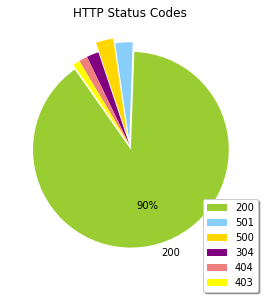

In [11]:
import matplotlib.pyplot as plt


def pie_pct_format(value):
    """ Determine the appropriate format string for the pie chart percentage label
    Args:
        value: value of the pie slice
    Returns:
        str: formated string label; if the slice is too small to fit, returns an empty string for label
    """
    return '' if value < 7 else '%.0f%%' % value

fig = plt.figure(figsize=(4.5, 4.5), facecolor='white', edgecolor='white')
colors = ['yellowgreen', 'lightskyblue', 'gold', 'purple', 'lightcoral', 'yellow']
labels =[200, 501, 500, 304, 404, 403]
explode = (0.05, 0.05, 0.1, 0, 0, 0)
d=data['response_code'].value_counts()
patches, texts, autotexts = plt.pie(d, labels=labels, colors=colors,
                                    explode=explode, autopct=pie_pct_format,
                                    shadow=False,  startangle=125)
for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('')
        # If the slice is small to fit, don't show a text label
plt.title("HTTP Status Codes")
plt.legend(labels, loc=(0.80, -0.1), shadow=True)

pass

In [12]:
# get trigram and plot the top 20
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import re
stop_words = stopwords.words()

def cleaning(text):        
    # converting to lowercase, removing URL links, special characters, punctuations,digits...
    text = re.sub(" \d+", " ", str(text))
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text) 
    return text

dt = data['user_agent'].apply(cleaning)

def get_top_n_trigram(corpus, n=None):
    vec = TfidfVectorizer(ngram_range=(3, 3), stop_words=stop_words, smooth_idf=False).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
clean_data=dt.apply(cleaning)
common_words = get_top_n_trigram(clean_data, 15)
for word, freq in common_words:
    print("{0:35}{1:5.2f}".format(word,freq))

/home/rim/my_project_dir/my_project_env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'ҳай', 'ҳамин', 'ҳатто', 'ҳо', 'ҳол', 'ҳолате', 'әттеген', 'ӯим', 'آمين', 'أب', 'أخ', 

go http package                    32.00
mozilla windows nt                 22.46
windows nt wow64                   20.21
expanse indexes network            20.00
indexes network perimeters         20.00
network perimeters customers       20.00
perimeters customers questions     20.00
customers questions concerns       20.00
questions concerns please          20.00
concerns please reach              20.00
please reach scaninfo              20.00
reach scaninfo expanseinc          20.00
gecko 20100101 firefox             19.17
nt wow64 rv                        18.51
wow64 rv 47                        18.04


In [13]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [14]:
data['ip_address'].value_counts()[:10]

208.100.26.243    36
208.100.26.249    25
92.118.160.61     18
84.38.134.31      16
208.100.26.247    15
92.118.160.41     12
94.232.46.171     12
208.100.26.246    11
208.100.26.235     9
92.118.160.45      8
Name: ip_address, dtype: int64

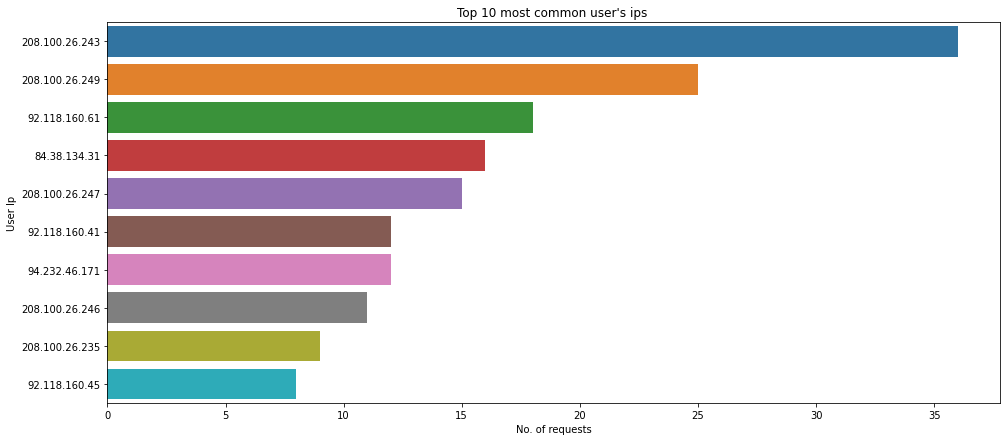

In [15]:
import seaborn as sns
athlete_order = data['ip_address'].value_counts().head(10).index
plt.figure(figsize=(16, 7))
sns.countplot(data=data, y='ip_address', order=athlete_order)
plt.title("Top 10 most common user's ips ")
plt.xlabel('No. of requests')
plt.ylabel('User Ip');

In [17]:
import pandas as pd
import numpy as np
import datetime as dt
import random

import matplotlib.pyplot as plt
%matplotlib inline

# Set some parameters to get good visuals - style to ggplot and size to 15,10
plt.style.use('ggplot')
import matplotlib.style as style
style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 8)

import seaborn as sns
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Feature Building

In [18]:
#trier les colonnes selon ip 
data.sort_values(['ip_address', 'timestamp'], inplace=True)

In [19]:
##Shift by one timestamp to find the change between current and next data point
data['shift_time'] = data.groupby(['ip_address'])['timestamp'].shift(1)

In [20]:
#time diffrence by minutes 
data['time_diff'] = (data['timestamp'] - data['shift_time']).dt.seconds//60

In [21]:
#extraire date
data['date'] = data['timestamp'].dt.date

In [22]:
#extraire l'heure
data['hour'] = data['timestamp'].dt.hour

In [23]:
data.fillna(0,inplace=True)

# IP Profile Building

In [ ]:
ip_col = 'ip_address'

# Count 

In [21]:
ip_counts = data.groupby(ip_col)['@timestamp'].count().reset_index()

In [22]:
ip_counts = ip_counts.rename(columns={'@timestamp':'total_count'})

# Daily counts average

In [23]:
#create index for each ip per day / count number of elements per  day per group
daily_counts = data.groupby([ip_col, 'date'])['@timestamp'].count().reset_index()

In [24]:
daily_counts = daily_counts.rename(columns={'@timestamp':'daily_counts'})

In [25]:
daily_counts_agg = daily_counts.groupby(ip_col).daily_counts.median().reset_index()

In [26]:
daily_counts_agg.head()

,ip_address,daily_counts
0,102.89.1.116,4.0
1,102.89.1.165,4.0
2,104.131.115.238,4.0
3,159.203.66.140,4.0
4,159.65.41.26,4.0


# avg login time

In [27]:
#mean time for every ip unity minutes
avg_timedelta_data = data.groupby(ip_col).agg({'time_diff':['mean','max']}).reset_index()

In [28]:
avg_timedelta_data.columns = avg_timedelta_data.columns.droplevel()

In [29]:
avg_timedelta_data.columns = [ip_col, 'mean_avg_login', 'max_avg_login']

In [30]:
avg_timedelta_data.fillna(0)

,ip_address,mean_avg_login,max_avg_login
0,102.89.1.116,17.250000,44.0
1,102.89.1.165,15.000000,47.0
2,104.131.115.238,29.500000,60.0
3,159.203.66.140,38.250000,84.0
4,159.65.41.26,50.250000,141.0
5,164.90.131.2,83.750000,146.0
6,164.90.135.74,42.500000,59.0
7,167.71.185.118,0.000000,0.0
8,192.99.18.122,0.000000,0.0
9,197.210.76.185,19.250000,68.0


# Full Feature Set

In [31]:
merge_1 = ip_counts.merge(daily_counts_agg, on=ip_col, how='left')

In [32]:
final_data = merge_1.merge(avg_timedelta_data, on=ip_col, how='left')

In [33]:
final_data.head()

,ip_address,total_count,daily_counts,mean_avg_login,max_avg_login
0,102.89.1.116,4,4.0,17.25,44.0
1,102.89.1.165,4,4.0,15.00,47.0
2,104.131.115.238,4,4.0,29.50,60.0
3,159.203.66.140,4,4.0,38.25,84.0
4,159.65.41.26,4,4.0,50.25,141.0


In [50]:
ip_map = final_data[ip_col].to_dict()

In [51]:
#if you don't specify the random_state in the code, then every time you run(execute) your code a new random value is generated 
#and the train and test datasets would have different values each time.
RANDOM_STATE = 123

# Data normalization

In [52]:
feature_cols = ['total_count', 'daily_counts','mean_avg_login', 'max_avg_login']

In [53]:
data_new = final_data[feature_cols]
data_new.fillna(0,inplace=True)

In [54]:
#normalization using min max values from 0 to 1
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

In [55]:
#data_new contains normalized data 
np_scaled = min_max_scaler.fit_transform(data_new)
data_new = pd.DataFrame(np_scaled, columns=feature_cols)

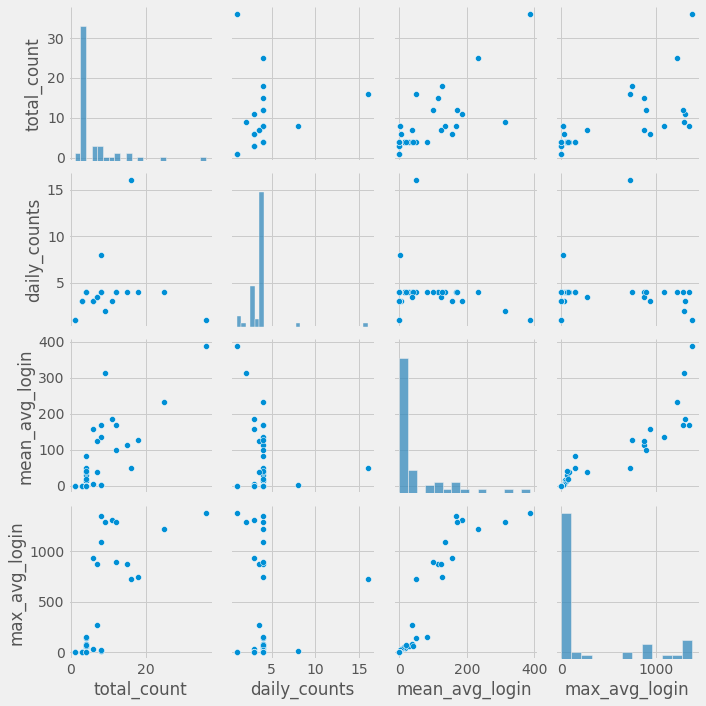

In [56]:
sns.pairplot(final_data[feature_cols])

# Identifying optimum number of clusters

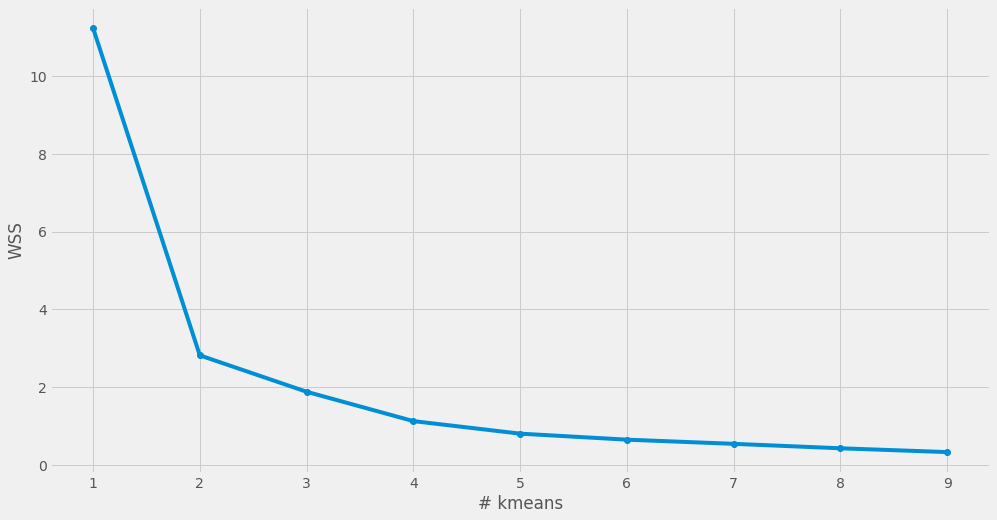

In [57]:
#Elbow method to choose the best k value of clusters
n_cluster = range(1,10)
cluster_wss = []

from sklearn.cluster import KMeans

for i in n_cluster:
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_STATE).fit(data_new) 
    cluster_wss.append(kmeans.inertia_)
    
plt.xlabel('# kmeans')
plt.ylabel('WSS')
plt.plot(n_cluster, cluster_wss, marker = 'o')
plt.show()

# K means : Model building

In [58]:
#number of clusters
n_cluster = range(1, 10)
#fit the data
kmeans = [KMeans(n_clusters=i, random_state=RANDOM_STATE).fit(data_new) for i in n_cluster]
cluster_model = kmeans[4]

In [59]:
#predict number of values for each cluster 
final_data['cluster'] = cluster_model.predict(data_new)

In [60]:
#Tsne for data reduction instead of pca 
#The point of t-SNE is to reduce the dimension to something that can be visualized in two dimension
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=RANDOM_STATE)

In [61]:
tsne_results = tsne.fit_transform(data_new)

/home/rim/my_project_dir/my_project_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/rim/my_project_dir/my_project_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 54 nearest neighbors...
[t-SNE] Indexed 55 samples in 0.001s...
[t-SNE] Computed neighbors for 55 samples in 0.106s...
[t-SNE] Computed conditional probabilities for sample 55 / 55
[t-SNE] Mean sigma: 0.293720
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.721786
[t-SNE] KL divergence after 300 iterations: 0.738578


In [62]:
#all rows first column
final_data['tsne-2d-one'] = tsne_results[:,0]
#all rows second column
final_data['tsne-2d-two'] = tsne_results[:,1]

In [63]:
tsne_cluster = final_data.groupby('cluster').agg({'tsne-2d-one':'mean', 'tsne-2d-two':'mean'}).reset_index()

In [64]:
#Centroids are data points representing the center of a cluster/each line is centroid of a cluster 
centers = cluster_model.cluster_centers_

In [65]:
points = np.asarray(data_new)

In [66]:
total_distance = pd.Series()

/tmp/ipykernel_3391/3059140193.py:1: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [67]:
#The distance from each point to each centroid is calculated.

def get_sum_square_distance(data, cluster_model):
    centers = cluster_model.cluster_centers_
    points = np.asarray(data[feature_cols])
    total_distance = pd.Series()
    for i in range(len(points)):
        distance = 0
        for j in range(len(centers)):
            a = np.linalg.norm(points[i] - centers[j])
            distance += a**2
        total_distance.at[i]=distance
    
    return total_distance    

In [68]:
final_data['sum_square_distance'] = get_sum_square_distance(data_new, cluster_model)

/tmp/ipykernel_3391/3085295679.py:6: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



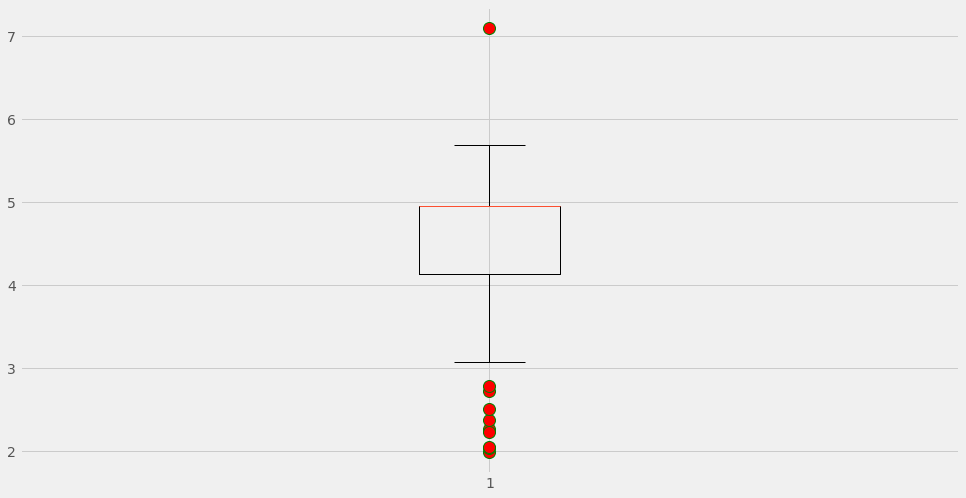

In [70]:
#boxplot help detect outliers
import matplotlib.pyplot as plt
import numpy as np

df=final_data['sum_square_distance']
 

# plot. Set color of marker edge
flierprops = dict(marker='o', markerfacecolor='r', markersize=12,
                  linestyle='none', markeredgecolor='g')
plt.boxplot(df, flierprops=flierprops)

plt.show()

In [71]:
Median=final_data['sum_square_distance'].median()

In [72]:
#if sum square distance is superior to median then we identify it as an anomaly 
cutoff=6
final_data['anomaly_kmeans'] = (final_data['sum_square_distance'] > cutoff).astype(int)
final_data['anomaly_kmeans'] = final_data['anomaly_kmeans'].map( {0: "normal", 1: "anomaly"} )

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

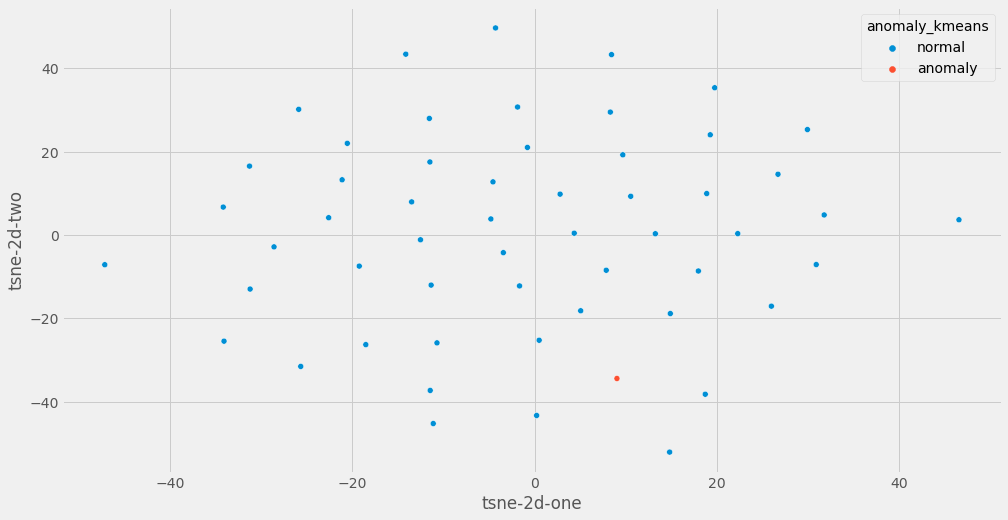

In [73]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="anomaly_kmeans",
    #palette=sns.color_palette("hls", 7),
    data=final_data,
    legend="full",
    alpha=1
)

In [74]:
final_data.loc[final_data['anomaly_kmeans']=="anomaly"]

,ip_address,total_count,daily_counts,mean_avg_login,max_avg_login,cluster,tsne-2d-one,tsne-2d-two,sum_square_distance,anomaly_kmeans
17,208.100.26.243,36,1.0,387.055556,1387.0,1,9.034627,-34.416214,7.094087,anomaly


# Isolation Forests

In [75]:
# Contamination factors indicates the percentage of data we believe to be outliers
#contamination=0.12 would identify the "top 12" percent of outliers.
outlier_fraction = 0.12

In [76]:
model =  IsolationForest(n_jobs=-1, n_estimators=200, max_features=3, random_state=RANDOM_STATE, contamination=outlier_fraction)

In [77]:
model.fit(data_new)

/home/rim/my_project_dir/my_project_env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



IsolationForest(contamination=0.12, max_features=3, n_estimators=200, n_jobs=-1,
                random_state=123)

In [78]:
# add the data to the main  
final_data['anomaly_isolated'] = pd.Series(model.predict(data_new))

In [79]:
final_data['anomaly_isolated'].value_counts()

 1    48
-1     7
Name: anomaly_isolated, dtype: int64

In [80]:
final_data['anomaly_isolated'] = final_data['anomaly_isolated'].map( {-1: "anomaly",1:"normal"} )

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

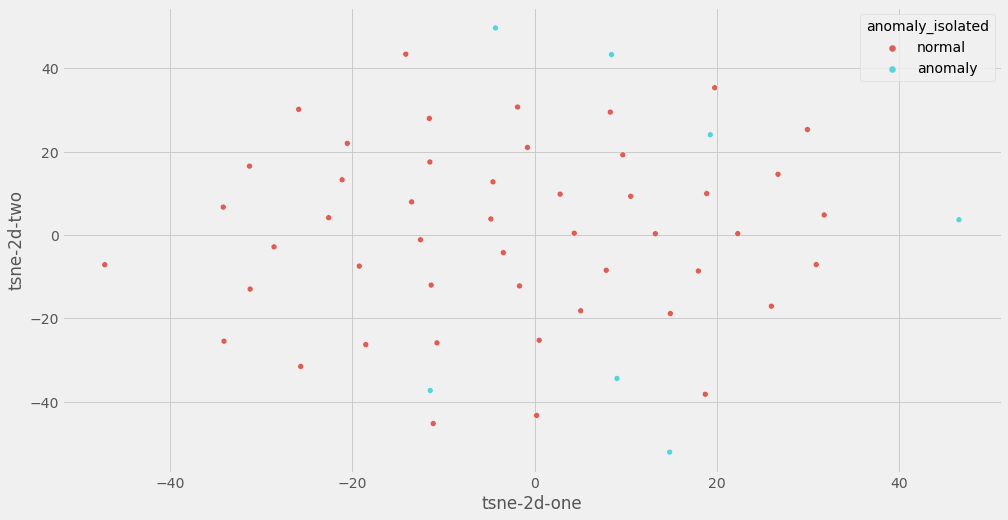

In [81]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="anomaly_isolated",
    palette=sns.color_palette("hls", 2),
    data=final_data,
    legend="full",
    alpha=1
)

In [85]:
total_counts_condition = (final_data['total_count'] >= final_data['total_count'].quantile(0.98)) 
daily_counts_condition =  (final_data['daily_counts'] >= final_data['daily_counts'].quantile(0.98))

In [86]:
final_data['anomaly_manual'] = (total_counts_condition | daily_counts_condition).astype(np.int)

/tmp/ipykernel_3391/1713091373.py:1: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [87]:
final_data.head()

,ip_address,total_count,daily_counts,mean_avg_login,max_avg_login,cluster,tsne-2d-one,tsne-2d-two,sum_square_distance,anomaly_kmeans,anomaly_isolated,anomaly_manual
0,102.89.1.116,4,4.0,17.25,44.0,0,2.796980,9.811254,4.613674,normal,normal,0
1,102.89.1.165,4,4.0,15.00,47.0,0,10.546717,9.292935,4.619777,normal,normal,0
2,104.131.115.238,4,4.0,29.75,61.0,0,22.295378,0.339290,4.444944,normal,normal,0
3,159.203.66.140,4,4.0,38.50,85.0,0,18.888924,9.952430,4.285148,normal,normal,0
4,159.65.41.26,4,4.0,50.25,141.0,0,13.249928,0.312172,3.993669,normal,normal,0


# DBSCAN

In [88]:
## Finding best values of eps and min_samples
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

# Defining the list of hyperparameters to try
eps_list=np.arange(start=0.1, stop=0.9, step=0.01)
min_sample_list=np.arange(start=2, stop=5, step=1)

# Creating empty data frame to store the silhouette scores for each trials
silhouette_scores_data=pd.DataFrame()

for eps_trial in eps_list:
    for min_sample_trial in min_sample_list:
        
        # Generating DBSAN clusters
        db = DBSCAN(eps=eps_trial, min_samples=min_sample_trial)
        if(len(np.unique(db.fit_predict(data_new)))>1):
            sil_score=silhouette_score(data_new, db.fit_predict(data_new))
        else:
            continue
        trial_parameters="eps:" + str(eps_trial.round(1)) +" min_sample :" + str(min_sample_trial)
        
        silhouette_scores_data=silhouette_scores_data.append(pd.DataFrame(data=[[sil_score,trial_parameters]], columns=["score", "parameters"]))
# Finding out the best hyperparameters with highest Score
silhouette_scores_data.sort_values(by='score', ascending=False).head(1)

/tmp/ipykernel_3391/1601554911.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3391/1601554911.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3391/1601554911.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3391/1601554911.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3391/1601554911.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3391/1601554911.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future

,score,parameters
0,0.775902,eps:0.4 min_sample :3


In [89]:
db = DBSCAN(eps=0.4, min_samples=3).fit(data_new)
labels = db.labels_

In [90]:
final_data['anomaly_debscan']=labels
data_new['labels']=labels

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

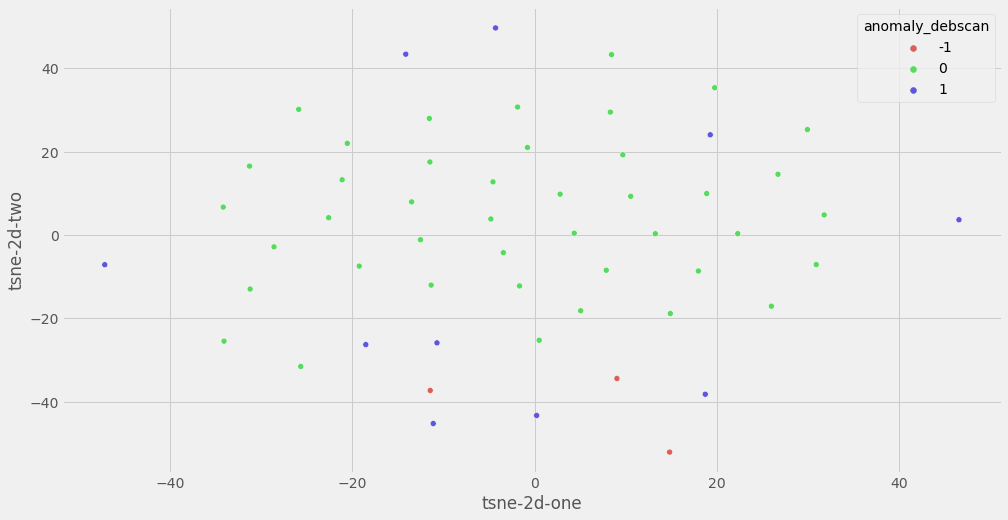

In [91]:
#we have two clusters and -1 represnts outliers 
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="anomaly_debscan",
    palette=sns.color_palette("hls", 3),
    data=final_data,
    legend="full",
    alpha=1
)

# Performance of Algo

K-means performance

In [92]:
#Silhouette Coefficient
#This score is between -1 and 1, where the higher the score the more well defined and distinct your clusters are.
import sklearn.metrics as metrics
my_model = KMeans(n_clusters=4, random_state=RANDOM_STATE).fit(data_new)
labels = my_model.labels_
metrics.silhouette_score(data_new,labels)

0.8626696950742848

In [93]:
from sklearn import metrics
from sklearn.cluster import KMeans

my_model = KMeans(n_clusters=4, random_state=RANDOM_STATE).fit(data_new)
labels = my_model.labels_
metrics.calinski_harabasz_score(data_new, labels)

335.4971813068741

In [94]:
#this score measures the similarity of your clusters, 
#meaning that the lower the score the better separation there is between your clusters
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

my_model = KMeans(n_clusters=4, random_state=RANDOM_STATE).fit(data_new)
labels = my_model.labels_
davies_bouldin_score(data_new, labels)

0.22858466003024086

DBSCAN performance

In [95]:
#Silhouette Coefficient
#This score is between -1 and 1, where the higher the score the more well defined and distinct your clusters are.
from sklearn import metrics
metrics.silhouette_score(data_new, data_new['labels'])

0.8625492701008161

Isolation forest performance

In [96]:
#we set a rule => max login is superior to 400 minutes we consider it as an anomaly
outliers_counter = (final_data['max_avg_login'] > 400).sum()
outliers_counter

13

In [97]:
#number of values consider it as an anomaly using isolation forest
print(len(final_data.loc[final_data['anomaly_isolated']=='anomaly']))

7


In [98]:
#Evaluating the model the number of : detected anomalies by the algorithm / number of defined anomaly by the rule 
print("Accuracy percentage:", 100*(len(final_data.loc[final_data['anomaly_isolated']=='anomaly'])/(outliers_counter)))

Accuracy percentage: 53.84615384615385


# Algorithms results 

In [99]:
title = 'Anomalous ip addresses detected using K-means'
header = 'header'

# Add MultiIndex Header
an = final_data.loc[final_data['anomaly_kmeans'] == "anomaly", ['ip_address']]
styler = an.style.set_caption(title).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'red'),
        ('font-size', '15px'),
        ('font-style', 'italic'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]
}]).hide_index()

display(styler)

/tmp/ipykernel_3391/3714664735.py:6: FutureWarning:

this method is deprecated in favour of `Styler.hide(axis='index')`



ip_address
208.100.26.243


In [100]:
title = 'Anomalous ip addresses detected using isolated_forest'
header = 'header'

# Add MultiIndex Header
an = final_data.loc[final_data['anomaly_isolated'] == "anomaly", ['ip_address']]
styler = an.style.set_caption(title).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'red'),
        ('font-size', '15px'),
        ('font-style', 'italic'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]
}]).hide_index()

display(styler)

/tmp/ipykernel_3391/1822350904.py:6: FutureWarning:

this method is deprecated in favour of `Styler.hide(axis='index')`



ip_address
20.102.71.10
208.100.26.235
208.100.26.243
208.100.26.246
208.100.26.249
84.38.134.31
92.118.160.61


In [101]:
title = 'Anomalous ip addresses detected using debscan'
header = 'header'

# Add MultiIndex Header
an = final_data.loc[final_data['anomaly_debscan'] == -1, ['ip_address']]
styler = an.style.set_caption(title).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'red'),
        ('font-size', '15px'),
        ('font-style', 'italic'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]
}]).hide_index()

display(styler)


/tmp/ipykernel_3391/331953407.py:6: FutureWarning:

this method is deprecated in favour of `Styler.hide(axis='index')`



ip_address
208.100.26.243
208.100.26.249
84.38.134.31
